In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [40]:
with open('tiny-shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[:])

In [41]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

In [120]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 100
num_steps = 25
batch_size = 32*num_steps

In [121]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [122]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

# Graph 

In [123]:
tf.reset_default_graph()

In [124]:
#----------input layer-----------------------
x = tf.placeholder(tf.int64, [None, num_steps])
y = tf.placeholder(tf.int64, [None, num_steps])
init_state = tf.placeholder(tf.float32,[None, num_neurons])
learning_rate = tf.placeholder(tf.float32,[])

embeddings = tf.get_variable('embedding_matrix', [vocab_size, num_neurons])

# Tensor of dims batch_size //num_steps x num_steps x num_neurons
x_transformed = tf.nn.embedding_lookup(embeddings, x)


#----------hidden layer-----------------------
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
#init_state = cell.zero_state(batch_size//num_steps,tf.float32)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_transformed, initial_state=init_state, dtype=tf.float32)


#----------output layer-----------------------
weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
bias = tf.Variable(tf.constant(0.0, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
prediction = tf.nn.softmax(logits)
prediction = tf.reshape(prediction, [-1, num_steps, vocab_size])

#----------loss and accuracy------------------
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 2),y), tf.float32))

#----------Trainer------------------
trainOp = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
init_vars = tf.initialize_all_variables()


# Training

In [126]:
print_after_num_steps = 10
adaptive_learning_rate = 0.005
restart_training = True

if restart_training:
    training_state = np.zeros((batch_size//num_steps,num_neurons),dtype=np.float32)

    trainHist = []
    accHist = []

    sess = tf.Session()
    sess.run(init_vars)

for num_epoch, epoch in enumerate(gen_epochs(raw_text_enc[:1000*batch_size],10,batch_size,num_steps)):
    
    #if num_epoch > 10:
    #   adaptive_learning_rate = 0.001
    
    for i, batch in enumerate(epoch):
        
        feed_dict = {x: batch[0], y: batch[1], init_state: training_state, learning_rate: adaptive_learning_rate}
        
        acc, lossVal, training_state, _ = sess.run([accuracy, loss, final_state, trainOp], feed_dict=feed_dict)
        trainHist.append(lossVal)
        accHist.append(acc)
        
        if i % print_after_num_steps == 0:
            clear_output()
            avg_loss = sum(trainHist[-print_after_num_steps:])/print_after_num_steps
            avg_acc = sum(accHist[-print_after_num_steps:])/print_after_num_steps
            
            print(num_epoch, i, avg_loss, avg_acc)
            

(0, 210, 2.2375022172927856, 0.37562499940395355)


KeyboardInterrupt: 

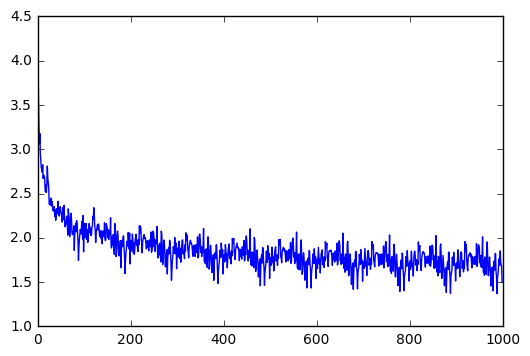

In [111]:
plt.plot(trainHist[:])

# Prediction

In [116]:
pred_batch=1

last_state = np.zeros((pred_batch,num_neurons),dtype=np.float32)
prev = np.random.choice(vocab_size,num_steps).astype(np.float32).reshape(1,num_steps)

digital_shakespeare = []

for i in range(10):
   
    pred, last_state = sess.run([prediction,final_state],feed_dict={x: prev, init_state: last_state})
    prev = np.argmax(pred,axis=2)
    
    
    
    digital_shakespeare +=  prev.reshape(-1).tolist()

In [107]:
print("".join([rev_trans_dic[d] for d in digital_shakespeare]))

NEIiU
IeUuh UG:,IUIo 
lS INLnS OrSs tp 
 USNfs l:h IAo:tf I ahot SS:UIiti
et Lf
het cneuhtee
SUn n  htao a  tousre rd :S:sobte ilsnpth ntisaesh
o
 neinhn   e eoo t nn   f To ng  httatnpdthCoohttoth soette eneoee eI ue erh th  h rhnd r dhnLts sneithetheteee tecoeeeh thoanh r er rn thltmd dstheuleetecnehedtheeheito  e r ss rt st  eerdern rstvtece te thaCtap es ehet eirt thlthetOiyitsttve htnr htheeher Rn ni  eedha oeha er e  hoetovhtvpsenmu atpnetntten  rei ee nt esn edm e ertttecnsapho yntotvsetntne eert  leeuhoo  he l e estnn ettatsteudtte hitntnt ettnhene  rr eertashe o tn eoe   tteatnp ele rhfshohnr ttthanr eetnecteei eue ethaeetkehnp emt d ntar tnset    d   tvpetoto ndhho l ttttebttheeeirhrao e rhothaeerl  erddn  evnsnteenhet d yttveieehtveoeo rd e  tetou e ndds e p npestntthltrnhnto   tntetooat eieee id   rhtthoin rndhtnrsd tn tateeieeusgted e  e  thothke snrds  er tnttattheuh  dteoes twvethoieneeerr tao rn  theenheundtsdd ebhknsedtthe   e r s  ietnoieo l eeerhttvtecetat heunrnsetn

In [109]:
pred.shape

(1, 25, 65)